In [1]:
%load_ext autoreload
%autoreload 3

import importlib
import math
import scipy
import pickle

import modules.data_preparation as data_prep
import modules.constants as const
importlib.reload(data_prep)
importlib.reload(const)

mio_runs = data_prep.get_mio_runs()

mio_runs

,Fitness function,Objective,Success
0,Branch distance,de.arnowelzel.android.periodical0,1
1,Branch distance,de.arnowelzel.android.periodical1,1
2,Branch distance,de.arnowelzel.android.periodical2,1
3,Branch distance,de.arnowelzel.android.periodical3,1
4,Branch distance,de.arnowelzel.android.periodical4,1
...,...,...,...
51995,Branch distance,de.arnowelzel.android.periodical493,1
51996,Branch distance,de.arnowelzel.android.periodical494,0
51997,Branch distance,de.arnowelzel.android.periodical495,1
51998,Branch distance,de.arnowelzel.android.periodical496,0


In the above dataframe, one row corresponds to one run and objective. For each run and objective, the success value is recorded. We have 2 fitness functions, 20 runs per objective and fitness function and 1300 objectives and 2 * 20 * 1300 = 52000, which is the amount of rows in this dataframe.

# RQ 3

Now, we want to know the success rate for every fitness function and objective. For this, we group by fitness function and objective and then sum the success values and divide them by 20.

In [2]:
grouped_df = mio_runs.groupby([const.FITNESS_FUNCTION, const.OBJECTIVE], as_index=False)

aggregated_df = grouped_df.aggregate(lambda l: sum(l)/20)

aggregated_df

,Fitness function,Objective,Success
0,Branch distance,de.arnowelzel.android.periodical0,0.90
1,Branch distance,de.arnowelzel.android.periodical1,0.80
2,Branch distance,de.arnowelzel.android.periodical10,0.65
3,Branch distance,de.arnowelzel.android.periodical100,0.60
4,Branch distance,de.arnowelzel.android.periodical101,0.90
...,...,...,...
2595,Code-based fitness,protect.rentalcalc95,1.00
2596,Code-based fitness,protect.rentalcalc96,1.00
2597,Code-based fitness,protect.rentalcalc97,1.00
2598,Code-based fitness,protect.rentalcalc98,1.00


The success values for both fitness functions are plotted in a violin plot each.

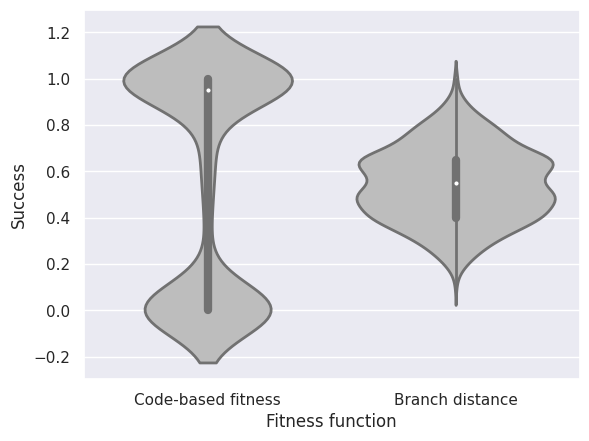

In [3]:
import importlib
import modules.constants as const
from pathlib import Path
from matplotlib import pyplot as plt
import seaborn as sns
importlib.reload(const)

output_file = Path(const.DIAGRAM_OUT_PATH) / "mio_RQ3.pdf"
sns.set_theme(style="darkgrid")

fig = plt.figure()
ax = sns.violinplot(data=aggregated_df, x=const.FITNESS_FUNCTION, y=const.SUCCESS, linewidth=2, color="#bdbdbd", order=[const.CODE_BASED, const.BRANCH_DISTANCE])
plt.savefig(output_file)
plt.close(fig)
fig

For code based fitness, most branches have a success rate of either (close to) zero or (close to) one. Note that success values lower than zero or higher than one are not possible and this is an artifact of the kernel density estimate. Half of the branches have success values very close to one, which is why the median is also very close to one. For branch distance, the distribution is rather balanced and centered around a median of about 0.5. (Hardly any) branches were never covered or covered any time.
From this plot alone, it cannot be assessed which fitness function results in more success in the mio execution. While the median of the success values of code-based fitness is much higher, branch distance does not have any completely unsuccessful branches. Also, because the distribution is so extremely based on the values zero and one, a change in a comparably small amount of data-points could dramatically change the location of the median.

This is why in the following, we represent the distribution of code-based fitness differently.

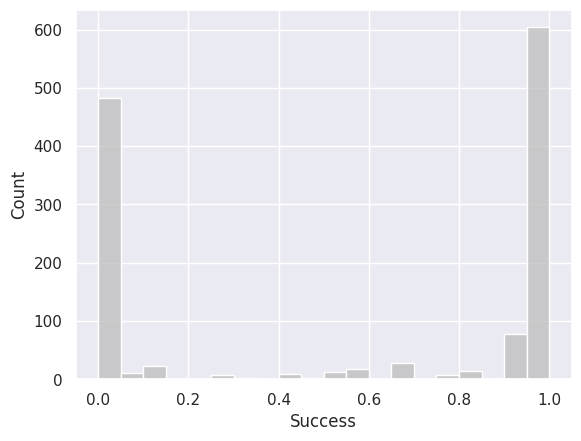

In [4]:
from matplotlib import pyplot as plt

from pathlib import Path
import seaborn as sns

sns.set_theme(style="darkgrid")

fig = plt.figure()
sns.histplot(aggregated_df.query("`Fitness function` == @const.CODE_BASED")[const.SUCCESS], binwidth=0.05, color="#bdbdbd")

# plt.savefig(output_file)
plt.close(fig)

fig

<Figure size 640x480 with 0 Axes>

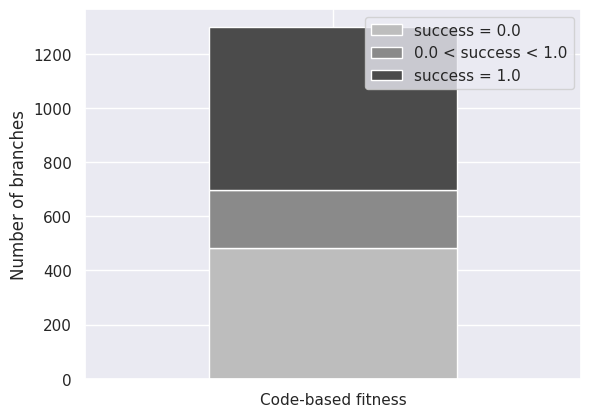

In [5]:
from pandas import DataFrame
fig = plt.figure()

success_values = aggregated_df.query("`Fitness function` == @const.CODE_BASED")[const.SUCCESS]

zero = 0
one = 0
between = 0

for val in success_values:
    if val == 1.0:
        one += 1
    elif val == 0.0:
        zero += 1
    else:
        between += 1

barplot_data_dict = {"success = 0.0": [zero], "0.0 < success < 1.0": [between], "success = 1.0": [one]}
barplot_data_df = DataFrame(barplot_data_dict, index=[const.CODE_BASED])

barplot_data_df.plot(kind='bar', stacked=True, color=["#bdbdbd", '#8a8a8a', "#4b4b4b"])
plt.ylabel("Number of branches")
plt.xticks(rotation=0)

plt.savefig(Path(const.DIAGRAM_OUT_PATH) / "mio_success_code_based_three_bins.pdf")
plt.close(fig)

fig

we now do the same for branch distance, but without plotting the plot

In [6]:
success_values_branch_distance = aggregated_df.query("`Fitness function` == @const.BRANCH_DISTANCE")[const.SUCCESS]

zero = 0
one = 0
between = 0

for val in success_values_branch_distance:
    if val == 1.0:
        one += 1
    elif val == 0.0:
        zero += 1
    else:
        between += 1

(zero, between, one)

(0, 1297, 3)

As can be seen here, the vast majority of branches actually either generate a success rate of one or a success rate of zero. There are only very few values in between.

Let's compare the averages of the success values

In [7]:
aggregated_df.drop(const.OBJECTIVE, axis=1).groupby(const.FITNESS_FUNCTION).aggregate(lambda l: sum(l) / len(l))

,Success
Fitness function,
Branch distance,0.543692
Code-based fitness,0.570385


As we can see, the difference in average success values is not nearly as pronounced as the difference in median success values.
While branch distance generates worse median and average success values than code-based fitness, it can be argued that the branch distance fitness function was actually more successful in the MIO runs than the code-based fitness function. The reason is that for branch distance, all branches have a reasonably high success rate and none have a success rate of 0. This means that by executing the search multiple times, or maybe by making a longer MIO run or by optimizing MIO, we can expect to be able to generate a test suite with 100% coverage. For code-based fitness on the other hand, there is a sizable amount of branches for which it is questionable, whether they can be covered with code-based fitness at all. Though most branches that did not yield a success value of 0 for code-based fitness actually yielded a success value of 1, which is a value branch distance (almost?) never achieved, it is doubtful that this effect is actually due to advantages of code-based fitness. It could very well be that MIO just spends more time on these objectives with code-based fitness compared to branch distance, since the other branches never yield improvements in fitness values and are thus not prioritized by the MIO algorithm.
This notion is supported by the fact that code-based fitness actually generated a large amount of entirely flat landscape walks.


# RQ4

First, we want to write the success values for both fitness functions in the same row for every objective. This results in one row for every objective, meaning we should get 1300 rows

In [8]:
import pandas as pd

branch_distance_df = aggregated_df.query("`Fitness function` == @const.BRANCH_DISTANCE")

code_based_df = aggregated_df.query("`Fitness function` == @const.CODE_BASED")

result = pd.merge(branch_distance_df, code_based_df, on=const.OBJECTIVE, suffixes=(" branch distance", " code-based"))

result.drop("Fitness function branch distance", axis=1, inplace=True)
result.drop("Fitness function code-based", axis=1, inplace=True)

result

,Objective,Success branch distance,Success code-based
0,de.arnowelzel.android.periodical0,0.90,0.30
1,de.arnowelzel.android.periodical1,0.80,1.00
2,de.arnowelzel.android.periodical10,0.65,0.00
3,de.arnowelzel.android.periodical100,0.60,1.00
4,de.arnowelzel.android.periodical101,0.90,0.00
...,...,...,...
1295,protect.rentalcalc95,0.45,1.00
1296,protect.rentalcalc96,0.50,1.00
1297,protect.rentalcalc97,0.45,1.00
1298,protect.rentalcalc98,0.50,1.00


For every objective, we calculate the p-value of the fisher exact test and the odds ratio. For the odds ratio, a value of one means that fitness function and mio success are independent, a smaller odds ratio means that code-based is more successful, a larger odds ratio mean that branch distance is more successful.

In [9]:
import modules.statistics as stat
importlib.reload(stat)
importlib.reload(const)

p_values_and_odds_ratios = result.copy(deep=True)

p_values = []
own_odds_ratios = []
for index, row in result.iterrows():
    stat_result = stat.calculate_fisher_exact_p_value_and_odds_ratio(row['Success branch distance'] * 20, row['Success code-based'] * 20, 20)
    p_values.append(stat_result[1])
    own_odds_ratios.append(stat.calculate_odds_ratio(row['Success code-based'] * 20, row['Success branch distance'] * 20, 20, 0.5))

p_values_and_odds_ratios[const.P_VALUE] = p_values
p_values_and_odds_ratios['Odds ratio'] = own_odds_ratios

p_values_and_odds_ratios

,Objective,Success branch distance,Success code-based,P-value,Odds ratio
0,de.arnowelzel.android.periodical0,0.90,0.30,2.443618e-04,0.060578
1,de.arnowelzel.android.periodical1,0.80,1.00,1.060291e-01,11.181818
2,de.arnowelzel.android.periodical10,0.65,0.00,1.288433e-05,0.013550
3,de.arnowelzel.android.periodical100,0.60,1.00,3.276003e-03,27.880000
4,de.arnowelzel.android.periodical101,0.90,0.00,3.351553e-09,0.003296
...,...,...,...,...,...
1295,protect.rentalcalc95,0.45,1.00,1.453066e-04,49.631579
1296,protect.rentalcalc96,0.50,1.00,4.359198e-04,41.000000
1297,protect.rentalcalc97,0.45,1.00,1.453066e-04,49.631579
1298,protect.rentalcalc98,0.50,1.00,4.359198e-04,41.000000


document the formula used for the odds ratio (+ the adding of the 0.5) -> steht so sogar im practical guide drinnen LOL

we create the bar plot for the p-values

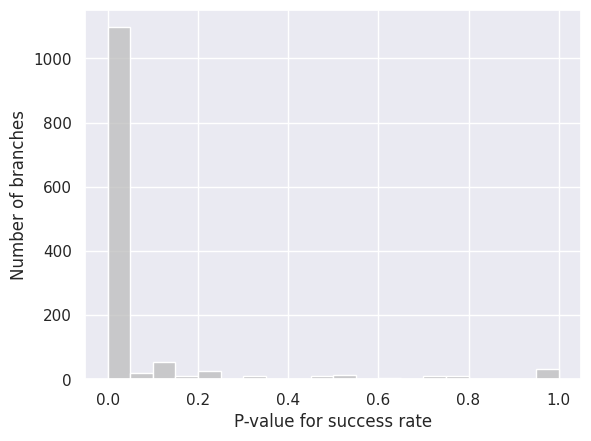

In [10]:
from matplotlib import pyplot as plt

import modules.constants as const
from pathlib import Path
import seaborn as sns

output_file = Path(const.DIAGRAM_OUT_PATH) / "mio_p-values.pdf"

sns.set_theme(style="darkgrid")



fig = plt.figure()
sns.histplot(p_values_and_odds_ratios[const.P_VALUE], binwidth=0.05, color="#bdbdbd")
plt.ylabel("Number of branches")
plt.xlabel("P-value for success rate")

plt.savefig(output_file)
plt.close(fig)

fig

we can show how many p-values are significant and how many aren't

significant: 1097
insignificant: 203


<Figure size 640x480 with 0 Axes>

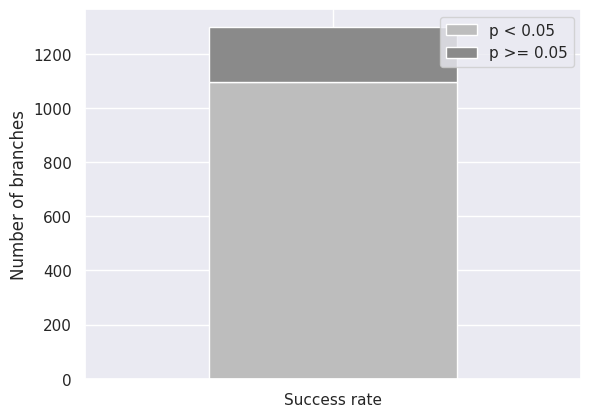

In [11]:
from pandas import DataFrame

p_values_significant = [x for x in p_values_and_odds_ratios[const.P_VALUE] if x < 0.05]
p_values_insignificant = [x for x in p_values_and_odds_ratios[const.P_VALUE] if x >= 0.05]

assert len(result.index) == len(p_values_significant) + len(p_values_insignificant)

fig = plt.figure()

number_significant = len(p_values_significant)
number_insignificant = len(p_values_insignificant)

barplot_data_dict = {"p < 0.05": [number_significant], "p >= 0.05": [number_insignificant]}
barplot_data_df = DataFrame(barplot_data_dict, index=["Success rate"])

# sns.barplot(data=barplot_data_df, color="#bdbdbd")

barplot_data_df.plot(kind='bar', stacked=True, color=["#bdbdbd", '#8a8a8a', 'green'])
plt.ylabel("Number of branches")
plt.xticks(rotation=0)

plt.savefig(Path(const.DIAGRAM_OUT_PATH) / "mio_p-values_two-bins.pdf")
plt.close(fig)

print("significant: " + str(len(p_values_significant)))
print("insignificant: " + str(len(p_values_insignificant)))

fig

Now lets put the own odds ratio on a logarithmic scale! Source: "A note on graphical presentation of estimated odds ratios from several clinical trials"

In [12]:
results_with_log = p_values_and_odds_ratios.copy()

odds_ratios_log = []
for index, row in results_with_log.iterrows():
    odds_ratio = row['Odds ratio']
    odds_ratios_log.append(math.log(odds_ratio, 10))

results_with_log["Log(odds ratio)"] = odds_ratios_log

results_with_log

,Objective,Success branch distance,Success code-based,P-value,Odds ratio,Log(odds ratio)
0,de.arnowelzel.android.periodical0,0.90,0.30,2.443618e-04,0.060578,-1.217686
1,de.arnowelzel.android.periodical1,0.80,1.00,1.060291e-01,11.181818,1.048512
2,de.arnowelzel.android.periodical10,0.65,0.00,1.288433e-05,0.013550,-1.868056
3,de.arnowelzel.android.periodical100,0.60,1.00,3.276003e-03,27.880000,1.445293
4,de.arnowelzel.android.periodical101,0.90,0.00,3.351553e-09,0.003296,-2.482016
...,...,...,...,...,...,...
1295,protect.rentalcalc95,0.45,1.00,1.453066e-04,49.631579,1.695758
1296,protect.rentalcalc96,0.50,1.00,4.359198e-04,41.000000,1.612784
1297,protect.rentalcalc97,0.45,1.00,1.453066e-04,49.631579,1.695758
1298,protect.rentalcalc98,0.50,1.00,4.359198e-04,41.000000,1.612784


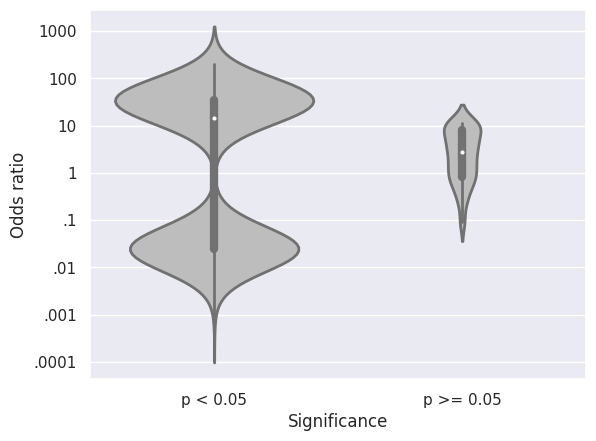

In [13]:
import math

sns.set_theme(style="darkgrid")

x_axis = "Significance"
y_axis = "Odds ratio"

significant_odds_ratios = results_with_log.query("`P-value` < 0.05")['Log(odds ratio)']

insignificant_odds_ratios = results_with_log.query("`P-value` >= 0.05")['Log(odds ratio)']

list_of_tuples = []
for size in significant_odds_ratios:
    list_of_tuples.append(("p < 0.05", size))
for size in insignificant_odds_ratios:
    list_of_tuples.append(("p >= 0.05", size))

effect_sizes_df = DataFrame(list_of_tuples, columns=[x_axis, y_axis])

fig = plt.figure()
sns.violinplot(data=effect_sizes_df, x=x_axis, y=y_axis, linewidth=2, color="#bdbdbd", order=["p < 0.05", "p >= 0.05"], scale="count")

plt.yticks(ticks=[-4, -3, -2, -1, 0, 1, 2, 3], labels=[".0001", ".001", ".01", ".1", "1", "10", "100", "1000"])


plt.savefig(Path(const.DIAGRAM_OUT_PATH) / "mio_effect_size.pdf")
plt.close(fig)
fig

As we can see, the distribution of effect sizes for high p-values is not based around 0, which means that we could probably get a sharper picture by increasing the number of repetitions per app. This is not a huge issue though, since most branches do in fact yield significant differences.

## Interpretation:
How much better is code-based in contrast to branch distance?

For the branches were significant differences were found, more branches are positive than negative. This means that there are more branches for which code-based fitness was more successful than there are branches for which branch distance was more successful.
With the same argument as above, it can be argued that this does not in fact show that code-based fitness is better than branch distance.

The effect sizes look rather symmetrical around 0, which makes sense considering that in RQ3, code-based had successes of 0 and 1 mainly, branch distance hat success of roughly 0.5

We now want to draw the same diagram for all objectives regardless of the significance level

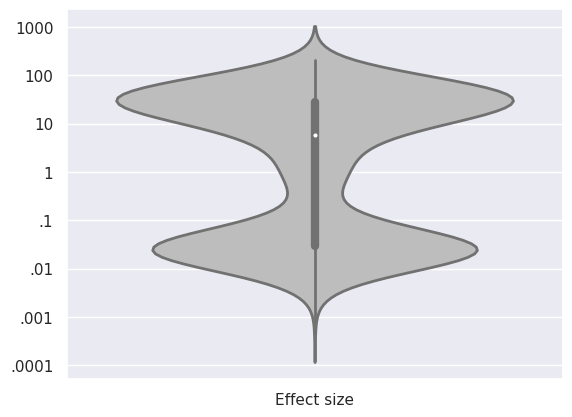

In [14]:
import math

sns.set_theme(style="darkgrid")

x_axis = "Significance"
y_axis = "Odds ratio"

effect_sizes_values = list(results_with_log['Log(odds ratio)'])

effect_size_all_df = DataFrame(effect_sizes_values, columns=["Effect size"])

fig = plt.figure()
sns.violinplot(data=effect_size_all_df, linewidth=2, color="#bdbdbd")
plt.savefig(Path(const.DIAGRAM_OUT_PATH) / "mio_effect_size_aggr.pdf")
plt.yticks(ticks=[-4, -3, -2, -1, 0, 1, 2, 3], labels=[".0001", ".001", ".01", ".1", "1", "10", "100", "1000"])
plt.close(fig)
fig

# RQ5

What do we expect from RQ5?

When comparing the effect sizes of the success rates with the effect sizes of the measures of neutrality, we expect that the branches where code-based fitness results in worse success values are the same branches where code-based fitness results in higher neutrality. For the branches where code-based fitness results in better success values we do not expect that there is a clear relation to the effect sizes of the neutrality measures.

first, we get all the odds ratios in a dataframe (all 1300 objectives that we can possibly use for RQ5):

In [15]:
mio_df = results_with_log.copy(deep=True)
mio_df.rename(columns={'P-value': 'P-value MIO'}, inplace=True)
mio_df.drop(["Success branch distance", "Success code-based", "Odds ratio"], axis=1, inplace=True)

mio_df

,Objective,P-value MIO,Log(odds ratio)
0,de.arnowelzel.android.periodical0,2.443618e-04,-1.217686
1,de.arnowelzel.android.periodical1,1.060291e-01,1.048512
2,de.arnowelzel.android.periodical10,1.288433e-05,-1.868056
3,de.arnowelzel.android.periodical100,3.276003e-03,1.445293
4,de.arnowelzel.android.periodical101,3.351553e-09,-2.482016
...,...,...,...
1295,protect.rentalcalc95,1.453066e-04,1.695758
1296,protect.rentalcalc96,4.359198e-04,1.612784
1297,protect.rentalcalc97,1.453066e-04,1.695758
1298,protect.rentalcalc98,4.359198e-04,1.612784


In [16]:
def getMannWhitneyUTestDict(input_file, measure):
    measure_values = pd.read_csv(input_file)
    objectives = measure_values['Objective'].drop_duplicates()

    statistics_df = {}

    for objective in objectives:
        branch_distance_list = measure_values[(measure_values[const.FITNESS_FUNCTION] == const.BRANCH_DISTANCE) & (measure_values[const.OBJECTIVE] == objective)][measure]
        code_based_list = measure_values[(measure_values[const.FITNESS_FUNCTION] == const.CODE_BASED) & (measure_values[const.OBJECTIVE] == objective)][measure]
        assert len(branch_distance_list) == 20
        assert len(code_based_list) == 20
        statistics_df[objective] = stat.calculate_mann_whitney_p_value(list(code_based_list), list(branch_distance_list))
    return statistics_df

In [17]:
import modules.measures as measures
importlib.reload(measures)

neutrality_volume_dict_statistics = getMannWhitneyUTestDict("store2/neutrality_volume_measure_df_with_objectives.csv", const.NEUTRALITY_VOLUME)

In [18]:
neutrality_volume_results = pd.DataFrame.from_dict(neutrality_volume_dict_statistics, orient="index", columns=['p-value', 'effect size'])
neutrality_volume_results.rename(columns={'p-value': 'P-value neutrality volume', 'effect size': 'Effect size neutrality volume'}, inplace=True)
neutrality_volume_results.reset_index(inplace=True)
neutrality_volume_results.rename(columns={'index': 'Objective'}, inplace=True)

neutrality_volume_results

,Objective,P-value neutrality volume,Effect size neutrality volume
0,com.woefe.shoppinglist0,1.124673e-08,0.00000
1,com.woefe.shoppinglist1,2.501190e-01,0.60750
2,com.woefe.shoppinglist2,9.659334e-04,0.80625
3,com.woefe.shoppinglist3,3.554657e-04,0.83125
4,com.woefe.shoppinglist4,1.409691e-03,0.79625
...,...,...,...
2602,de.rampro.activitydiary1002,8.006545e-09,0.00000
2603,de.rampro.activitydiary1003,6.709848e-08,1.00000
2604,de.rampro.activitydiary1004,1.573521e-05,0.10000
2605,de.rampro.activitydiary1005,6.596955e-08,0.00000


In [19]:
neutrality_distance_dict_statistics = getMannWhitneyUTestDict("store2/neutrality_distance_measure_df_with_objectives.csv", const.NEUTRALITY_DISTANCE)

neutrality_distance_result = pd.DataFrame.from_dict(neutrality_distance_dict_statistics, orient="index", columns=['p-value', 'effect size'])
neutrality_distance_result.rename(columns={'p-value': 'P-value neutrality distance', 'effect size': 'Effect size neutrality distance'}, inplace=True)
neutrality_distance_result.reset_index(inplace=True)
neutrality_distance_result.rename(columns={'index': 'Objective'}, inplace=True)

neutrality_distance_result

,Objective,P-value neutrality distance,Effect size neutrality distance
0,com.woefe.shoppinglist0,8.080260e-09,1.00000
1,com.woefe.shoppinglist1,2.338418e-02,0.30375
2,com.woefe.shoppinglist2,1.834480e-02,0.29375
3,com.woefe.shoppinglist3,4.300226e-03,0.24250
4,com.woefe.shoppinglist4,1.602003e-02,0.28875
...,...,...,...
2602,de.rampro.activitydiary1002,7.140665e-09,1.00000
2603,de.rampro.activitydiary1003,1.623973e-05,0.11625
2604,de.rampro.activitydiary1004,1.869430e-03,0.21375
2605,de.rampro.activitydiary1005,1.939754e-04,0.84500


In [20]:
ic_dict_statistics = getMannWhitneyUTestDict("store2/information_content_measure_df_with_objectives.csv", const.INFORMATION_CONTENT)

ic_result = pd.DataFrame.from_dict(ic_dict_statistics, orient="index", columns=['p-value', 'effect size'])
ic_result.rename(columns={'p-value': 'P-value information content', 'effect size': 'Effect size information content'}, inplace=True)
ic_result.reset_index(inplace=True)
ic_result.rename(columns={'index': 'Objective'}, inplace=True)


ic_result

,Objective,P-value information content,Effect size information content
0,com.woefe.shoppinglist0,1.126657e-08,0.0000
1,com.woefe.shoppinglist1,1.599724e-05,0.9000
2,com.woefe.shoppinglist2,6.795615e-08,1.0000
3,com.woefe.shoppinglist3,1.064569e-07,0.9925
4,com.woefe.shoppinglist4,2.355659e-06,0.9375
...,...,...,...
2602,de.rampro.activitydiary1002,8.006545e-09,0.0000
2603,de.rampro.activitydiary1003,6.795615e-08,1.0000
2604,de.rampro.activitydiary1004,1.413569e-05,0.0975
2605,de.rampro.activitydiary1005,6.766921e-08,0.0000


In [21]:
auto_dict_statistics = getMannWhitneyUTestDict("store2/autocorrelation1_measure_df_with_objectives.csv", const.AUTOCORRELATION(1))

auto_result = pd.DataFrame.from_dict(auto_dict_statistics, orient="index", columns=['p-value', 'effect size'])
auto_result.rename(columns={'p-value': 'P-value autocorrelation k=1', 'effect size': 'Effect size autocorrelation k=1'}, inplace=True)
auto_result.reset_index(inplace=True)
auto_result.rename(columns={'index': 'Objective'}, inplace=True)

auto_result

,Objective,P-value autocorrelation k=1,Effect size autocorrelation k=1
0,com.woefe.shoppinglist0,9.523810e-02,NaN
1,com.woefe.shoppinglist1,6.795615e-08,0.0000
2,com.woefe.shoppinglist2,1.917712e-07,0.0175
3,com.woefe.shoppinglist3,1.657079e-07,0.0150
4,com.woefe.shoppinglist4,6.916583e-07,0.0400
...,...,...,...
2602,de.rampro.activitydiary1002,NaN,NaN
2603,de.rampro.activitydiary1003,9.172773e-08,0.0050
2604,de.rampro.activitydiary1004,4.680403e-05,0.1225
2605,de.rampro.activitydiary1005,2.959754e-07,0.0250


In [22]:
from functools import reduce

data_frames = [mio_df, neutrality_volume_results, neutrality_distance_result, ic_result, auto_result]

master_df = reduce(lambda left, right: pd.merge(left, right, on=['Objective']), data_frames)

master_df

,Objective,P-value MIO,Log(odds ratio),P-value neutrality volume,Effect size neutrality volume,P-value neutrality distance,Effect size neutrality distance,P-value information content,Effect size information content,P-value autocorrelation k=1,Effect size autocorrelation k=1
0,de.arnowelzel.android.periodical0,2.443618e-04,-1.217686,5.207711e-07,0.9650,1.335560e-04,0.16000,1.234635e-07,0.99000,6.795615e-08,0.0000
1,de.arnowelzel.android.periodical1,1.060291e-01,1.048512,8.006545e-09,0.0000,7.355782e-09,1.00000,8.006545e-09,0.00000,NaN,NaN
2,de.arnowelzel.android.periodical10,1.288433e-05,-1.868056,2.536625e-07,0.9775,3.017955e-02,0.31875,1.657079e-07,0.98500,6.795615e-08,0.0000
3,de.arnowelzel.android.periodical100,3.276003e-03,1.445293,4.191375e-07,0.0325,8.230032e-02,0.66125,5.532789e-07,0.03625,6.916583e-07,0.0400
4,de.arnowelzel.android.periodical101,3.351553e-09,-2.482016,8.006545e-09,0.0000,7.646820e-09,1.00000,8.006545e-09,0.00000,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
1295,protect.rentalcalc95,1.453066e-04,1.695758,8.006545e-09,0.0000,6.228241e-09,1.00000,8.006545e-09,0.00000,NaN,NaN
1296,protect.rentalcalc96,4.359198e-04,1.612784,6.339939e-08,0.0000,8.812814e-06,0.91000,6.766921e-08,0.00000,1.609813e-04,0.1500
1297,protect.rentalcalc97,1.453066e-04,1.695758,8.006545e-09,0.0000,6.299128e-09,1.00000,8.006545e-09,0.00000,NaN,NaN
1298,protect.rentalcalc98,4.359198e-04,1.612784,6.690917e-08,0.0000,1.903538e-06,0.94000,6.757379e-08,0.00000,1.802969e-06,0.0575


In [23]:
master_df.query("`P-value MIO` < 0.05 and `P-value neutrality volume` < 0.05")

,Objective,P-value MIO,Log(odds ratio),P-value neutrality volume,Effect size neutrality volume,P-value neutrality distance,Effect size neutrality distance,P-value information content,Effect size information content,P-value autocorrelation k=1,Effect size autocorrelation k=1
0,de.arnowelzel.android.periodical0,2.443618e-04,-1.217686,5.207711e-07,0.9650,1.335560e-04,0.16000,1.234635e-07,0.99000,6.795615e-08,0.0000
2,de.arnowelzel.android.periodical10,1.288433e-05,-1.868056,2.536625e-07,0.9775,3.017955e-02,0.31875,1.657079e-07,0.98500,6.795615e-08,0.0000
3,de.arnowelzel.android.periodical100,3.276003e-03,1.445293,4.191375e-07,0.0325,8.230032e-02,0.66125,5.532789e-07,0.03625,6.916583e-07,0.0400
4,de.arnowelzel.android.periodical101,3.351553e-09,-2.482016,8.006545e-09,0.0000,7.646820e-09,1.00000,8.006545e-09,0.00000,NaN,NaN
9,de.arnowelzel.android.periodical106,2.019602e-02,1.264329,6.587623e-08,0.0000,2.163568e-04,0.84250,6.700376e-08,0.00000,7.947948e-07,0.0425
...,...,...,...,...,...,...,...,...,...,...,...
1295,protect.rentalcalc95,1.453066e-04,1.695758,8.006545e-09,0.0000,6.228241e-09,1.00000,8.006545e-09,0.00000,NaN,NaN
1296,protect.rentalcalc96,4.359198e-04,1.612784,6.339939e-08,0.0000,8.812814e-06,0.91000,6.766921e-08,0.00000,1.609813e-04,0.1500
1297,protect.rentalcalc97,1.453066e-04,1.695758,8.006545e-09,0.0000,6.299128e-09,1.00000,8.006545e-09,0.00000,NaN,NaN
1298,protect.rentalcalc98,4.359198e-04,1.612784,6.690917e-08,0.0000,1.903538e-06,0.94000,6.757379e-08,0.00000,1.802969e-06,0.0575


PearsonRResult(statistic=0.0362383186433785, pvalue=0.2452403311092182)


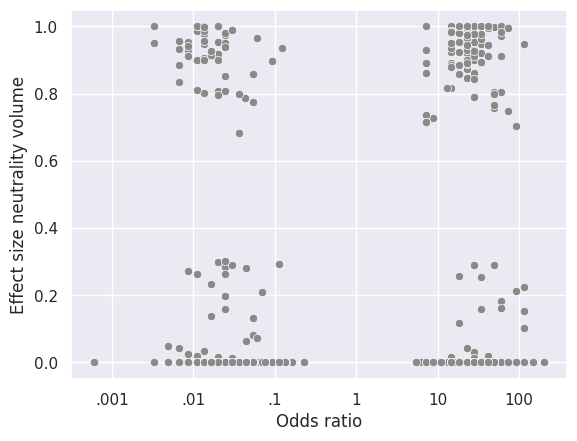

In [24]:
sns.set_theme(style="darkgrid")

neutrality_volume_dict_for_corr = master_df.query("`P-value MIO` < 0.05 and `P-value neutrality volume` < 0.05")

fig = plt.figure()

sns.scatterplot(data=neutrality_volume_dict_for_corr, x="Log(odds ratio)", y="Effect size neutrality volume", color='#8a8a8a')

plt.xticks(ticks=[-3, -2, -1, 0, 1, 2], labels=[".001", ".01", ".1", "1", "10", "100"])
plt.xlabel("Odds ratio")

plt.savefig(Path(const.DIAGRAM_OUT_PATH) / "big_corr_neutrality_volume.pdf")

plt.close(fig)

print(scipy.stats.pearsonr(neutrality_volume_dict_for_corr['Log(odds ratio)'], neutrality_volume_dict_for_corr['Effect size neutrality volume']))

fig

In [25]:
from scipy.stats import fisher_exact
import math

smaller_smaller = len(master_df.query("`P-value MIO` < 0.05 and `P-value neutrality volume` < 0.05").query("`Log(odds ratio)` < 1 and `Effect size neutrality volume` < 0.5").index)
smaller_larger = len(master_df.query("`P-value MIO` < 0.05 and `P-value neutrality volume` < 0.05").query("`Log(odds ratio)` < 1 and `Effect size neutrality volume` > 0.5").index)
larger_smaller = len(master_df.query("`P-value MIO` < 0.05 and `P-value neutrality volume` < 0.05").query("`Log(odds ratio)` > 1 and `Effect size neutrality volume` < 0.5").index)
larger_larger = len(master_df.query("`P-value MIO` < 0.05 and `P-value neutrality volume` < 0.05").query("`Log(odds ratio)` > 1 and `Effect size neutrality volume` > 0.5").index)

print("fisher exact: " + str(fisher_exact([[smaller_larger, smaller_smaller], [larger_larger, larger_smaller]])))
print("odds ratio oder so: " + str((smaller_larger * larger_smaller) / (smaller_smaller * larger_larger)))

print("odds ratio logarithmed: " + str(math.log((smaller_larger * larger_smaller) / (smaller_smaller * larger_larger), 10)))

print("datapoints: " + str(smaller_smaller + smaller_larger + larger_smaller + larger_larger))

matrix = pd.DataFrame()
matrix['smaller'] = [smaller_larger, smaller_smaller]
matrix['larger'] = [larger_larger, larger_smaller]
matrix.index = ["larger", 'smaller']
matrix

fisher exact: (0.7401960784313726, 0.10655885797389139)
odds ratio oder so: 0.7401960784313726
odds ratio logarithmed: -0.1306532201327293
datapoints: 1030


,smaller,larger
larger,60,85
smaller,432,453


PearsonRResult(statistic=-0.013463901270070116, pvalue=0.6903357741076845)


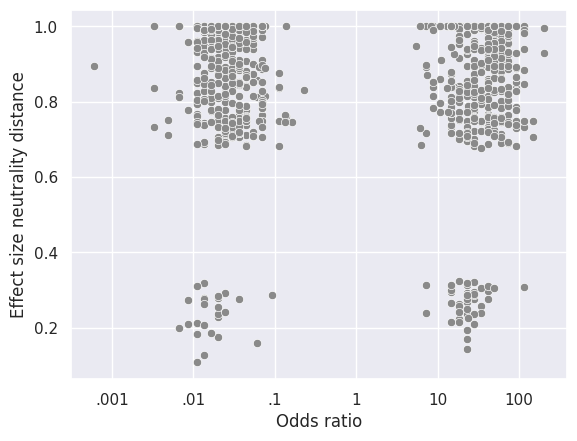

In [26]:
sns.set_theme(style="darkgrid")

neutrality_distance_dict_for_corr = master_df.query("`P-value MIO` < 0.05 and `P-value neutrality distance` < 0.05")

fig = plt.figure()

sns.scatterplot(data=neutrality_distance_dict_for_corr, x="Log(odds ratio)", y="Effect size neutrality distance", color='#8a8a8a')

plt.xticks(ticks=[-3, -2, -1, 0, 1, 2], labels=[".001", ".01", ".1", "1", "10", "100"])
plt.xlabel("Odds ratio")

plt.savefig(Path(const.DIAGRAM_OUT_PATH) / "big_corr_neutrality_distance.pdf")

plt.close(fig)

print(scipy.stats.pearsonr(neutrality_distance_dict_for_corr['Log(odds ratio)'], neutrality_distance_dict_for_corr['Effect size neutrality distance']))

fig

In [27]:
from scipy.stats import fisher_exact
import math

smaller_smaller = len(master_df.query("`P-value MIO` < 0.05 and `P-value neutrality distance` < 0.05").query("`Log(odds ratio)` < 1 and `Effect size neutrality distance` < 0.5").index)
smaller_larger = len(master_df.query("`P-value MIO` < 0.05 and `P-value neutrality distance` < 0.05").query("`Log(odds ratio)` < 1 and `Effect size neutrality distance` > 0.5").index)
larger_smaller = len(master_df.query("`P-value MIO` < 0.05 and `P-value neutrality distance` < 0.05").query("`Log(odds ratio)` > 1 and `Effect size neutrality distance` < 0.5").index)
larger_larger = len(master_df.query("`P-value MIO` < 0.05 and `P-value neutrality distance` < 0.05").query("`Log(odds ratio)` > 1 and `Effect size neutrality distance` > 0.5").index)

print("fisher exact: " + str(fisher_exact([[smaller_larger, smaller_smaller], [larger_larger, larger_smaller]])))
print("odds ratio oder so: " + str((smaller_larger * larger_smaller) / (smaller_smaller * larger_larger)))

print("odds ratio logarithmed: " + str(math.log((smaller_larger * larger_smaller) / (smaller_smaller * larger_larger), 10)))

print("datapoints: " + str(smaller_smaller + smaller_larger + larger_smaller + larger_larger))

matrix = pd.DataFrame()
matrix['smaller'] = [smaller_larger, smaller_smaller]
matrix['larger'] = [larger_larger, larger_smaller]
matrix.index = ["larger", 'smaller']
matrix

fisher exact: (1.578099838969404, 0.08432283900280793)
odds ratio oder so: 1.578099838969404
odds ratio logarithmed: 0.19813447551591462
datapoints: 878


,smaller,larger
larger,392,414
smaller,27,45


PearsonRResult(statistic=0.02058917775652305, pvalue=0.5073733862365315)


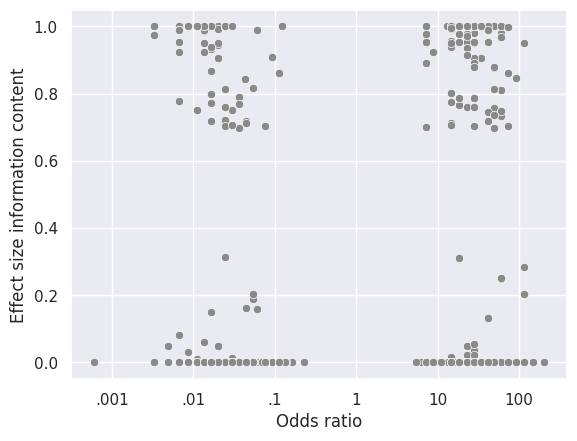

In [28]:
sns.set_theme(style="darkgrid")

information_content_dict_for_corr = master_df.query("`P-value MIO` < 0.05 and `P-value information content` < 0.05")

fig = plt.figure()

sns.scatterplot(data=information_content_dict_for_corr, x="Log(odds ratio)", y="Effect size information content", color='#8a8a8a')
plt.xticks(ticks=[-3, -2, -1, 0, 1, 2], labels=[".001", ".01", ".1", "1", "10", "100"])
plt.xlabel("Odds ratio")

plt.savefig(Path(const.DIAGRAM_OUT_PATH) / "big_corr_information_content.pdf")

plt.close(fig)

print(scipy.stats.pearsonr(information_content_dict_for_corr['Log(odds ratio)'], information_content_dict_for_corr['Effect size information content']))

fig

In [29]:
from scipy.stats import fisher_exact
import math

smaller_smaller = len(master_df.query("`P-value MIO` < 0.05 and `P-value information content` < 0.05").query("`Log(odds ratio)` < 1 and `Effect size information content` < 0.5").index)
smaller_larger = len(master_df.query("`P-value MIO` < 0.05 and `P-value information content` < 0.05").query("`Log(odds ratio)` < 1 and `Effect size information content` > 0.5").index)
larger_smaller = len(master_df.query("`P-value MIO` < 0.05 and `P-value information content` < 0.05").query("`Log(odds ratio)` > 1 and `Effect size information content` < 0.5").index)
larger_larger = len(master_df.query("`P-value MIO` < 0.05 and `P-value information content` < 0.05").query("`Log(odds ratio)` > 1 and `Effect size information content` > 0.5").index)

print("fisher exact: " + str(fisher_exact([[smaller_larger, smaller_smaller], [larger_larger, larger_smaller]])))
print("odds ratio oder so: " + str((smaller_larger * larger_smaller) / (smaller_smaller * larger_larger)))

print("odds ratio logarithmed: " + str(math.log((smaller_larger * larger_smaller) / (smaller_smaller * larger_larger), 10)))

print("datapoints: " + str(smaller_smaller + smaller_larger + larger_smaller + larger_larger))

matrix = pd.DataFrame()
matrix['smaller'] = [smaller_larger, smaller_smaller]
matrix['larger'] = [larger_larger, larger_smaller]
matrix.index = ["larger", 'smaller']
matrix

fisher exact: (0.8320078546882671, 0.2796535802558487)
odds ratio oder so: 0.8320078546882671
odds ratio logarithmed: -0.07987257367121206
datapoints: 1039


,smaller,larger
larger,76,97
smaller,420,446


PearsonRResult(statistic=-0.06562936604122972, pvalue=0.10537257671036754)


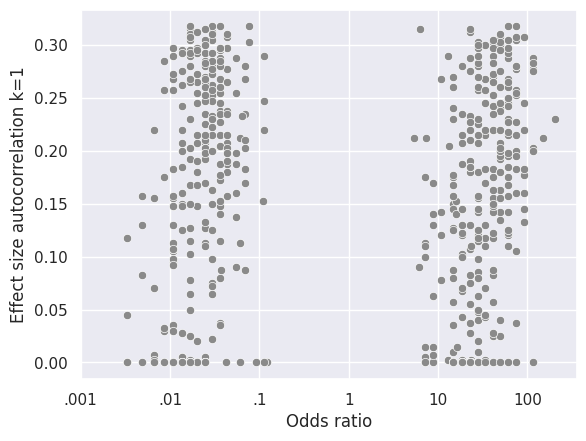

In [30]:
sns.set_theme(style="darkgrid")

autocorrelation_dict_for_corr = master_df.query("`P-value MIO` < 0.05 and `P-value autocorrelation k=1` < 0.05")

fig = plt.figure()

sns.scatterplot(data=autocorrelation_dict_for_corr, x="Log(odds ratio)", y="Effect size autocorrelation k=1", color='#8a8a8a')

plt.xticks(ticks=[-3, -2, -1, 0, 1, 2], labels=[".001", ".01", ".1", "1", "10", "100"])
plt.xlabel("Odds ratio")

plt.savefig(Path(const.DIAGRAM_OUT_PATH) / "big_corr_autocorrelation.pdf")

plt.close(fig)

print(scipy.stats.pearsonr(autocorrelation_dict_for_corr.query("not `Effect size autocorrelation k=1`.isnull()")['Log(odds ratio)'], autocorrelation_dict_for_corr.query("not `Effect size autocorrelation k=1`.isnull()")['Effect size autocorrelation k=1']))

fig

In [31]:
from scipy.stats import fisher_exact
import math

smaller_smaller = len(master_df.query("`P-value MIO` < 0.05 and `P-value autocorrelation k=1` < 0.05").query("`Log(odds ratio)` < 1 and `Effect size autocorrelation k=1` < 0.5").index)
smaller_larger = len(master_df.query("`P-value MIO` < 0.05 and `P-value autocorrelation k=1` < 0.05").query("`Log(odds ratio)` < 1 and `Effect size autocorrelation k=1` > 0.5").index)
larger_smaller = len(master_df.query("`P-value MIO` < 0.05 and `P-value autocorrelation k=1` < 0.05").query("`Log(odds ratio)` > 1 and `Effect size autocorrelation k=1` < 0.5").index)
larger_larger = len(master_df.query("`P-value MIO` < 0.05 and `P-value autocorrelation k=1` < 0.05").query("`Log(odds ratio)` > 1 and `Effect size autocorrelation k=1` > 0.5").index)

print("fisher exact: " + str(fisher_exact([[smaller_larger, smaller_smaller], [larger_larger, larger_smaller]])))
print("odds ratio oder so: " + str(((smaller_larger + 0.5) * (larger_smaller + 0.5)) / ((smaller_smaller + 0.5) * (larger_larger + 0.5))))

print("odds ratio logarithmed: " + str(math.log(((smaller_larger + 0.5) * (larger_smaller + 0.5)) / ((smaller_smaller + 0.5) * (larger_larger + 0.5)), 10)))

print("datapoints: " + str(smaller_smaller + smaller_larger + larger_smaller + larger_larger))

matrix = pd.DataFrame()
matrix['smaller'] = [smaller_larger, smaller_smaller]
matrix['larger'] = [larger_larger, larger_smaller]
matrix.index = ["larger", 'smaller']
matrix

fisher exact: (nan, 1.0)
odds ratio oder so: 1.053781512605042
odds ratio logarithmed: 0.022750575102166888
datapoints: 610


,smaller,larger
larger,0,0
smaller,297,313
